In [16]:
import jax.numpy as jnp
from jax import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from scipy.stats import norm
import pandas as pd
from IPython.display import display, HTML

In [2]:
data = jnp.load('./data_assignment3.npz')
x_data, y_data = data['x'], data['t']

In [55]:
design_matrix = lambda x: jnp.column_stack((jnp.atleast_1d(x), jnp.ones_like(jnp.atleast_1d(x))))


## Part 2: Regression modelling using mixture of experts

*Mixture of experts (MoE) model for regression*

We consider two different linear models $\boldsymbol{y}_n= \boldsymbol{w}_0^T\boldsymbol{x}_n + e_n$ and $\boldsymbol{y}_n= \boldsymbol{w}_1^T\boldsymbol{x}_n +e_n$, with weights $\boldsymbol{w}_0$ and $\boldsymbol{w}_1$ in respect to two different regions of $\boldsymbol{x}_n$, controlled by the latent variable $z_n \in \{0,1\}$ which we let be Bernoulli distributed given the data $\boldsymbol{x}_n$ 
$$
z_n \mid \boldsymbol{v} \sim \operatorname{Ber}\left(\sigma\left(\boldsymbol{v}^T \boldsymbol{x}_n\right)\right),
$$
where $\boldsymbol(v)$ are parameters and $\boldsymbol{x}_n=[x_n,1]$.\
We then construct the conditional likelyhood as Gaussians for both data regions determined by the latent variable such that
$$
\begin{align*}
p\left(y_n \mid x_n, z_n, \boldsymbol{w}_0, \boldsymbol{w}_1, \sigma_0^2, \sigma_1^2\right)=\left\{\begin{array}{lll}
\mathcal{N}\left(y_n \mid \boldsymbol{w}_1^T \boldsymbol{x}_n, \sigma_1^2\right) & \text { if } & z_n=1, \\
\mathcal{N}\left(y_n \mid \boldsymbol{w}_0^T \boldsymbol{x}_n, \sigma_0^2\right) & \text { if } & z_n=0,
\end{array}=\mathcal{N}\left(y_n \mid \boldsymbol{w}_{z_n}^T \boldsymbol{x}_n, \sigma_{z_n}^2\right)\right.,
\end{align*}
$$
with noise variance $\sigma_{z_n}^2$. Adding the following generic priors, we write up the joint distribution
$$
\begin{align*}
\tau, \sigma_0^2, \sigma_1^2 & \sim \mathcal{N}_{+}(0,1), \\
w_0, w_1, \boldsymbol{v} & \sim \mathcal{N}\left(\mathbf{0}, \tau^2 \boldsymbol{I}\right), \\
y_n \mid z_n & \sim \mathcal{N}\left(\boldsymbol{w}_{z_n}^T \boldsymbol{x}_n, \sigma_{z_n}^2\right),
\end{align*}
$$
joint distribution:
$$

\begin{align*}
p\left(\boldsymbol{y}, \boldsymbol{w}_1, \boldsymbol{w}_0, \boldsymbol{v}, \boldsymbol{z}, \tau, \sigma_0, \sigma_1 \mid \boldsymbol{x}\right)= & {\left[\prod_{n=1}^N \mathcal{N}\left(y_n \mid \boldsymbol{w}_{z_n}^T \boldsymbol{x}_n, \sigma_{z_n}^2\right) \operatorname{Ber}\left(z_n \mid \sigma\left(\boldsymbol{v}^T \boldsymbol{x}_n\right)\right)\right] \mathcal{N}\left(\boldsymbol{w}_0 \mid \mathbf{0}, \tau^2 \boldsymbol{I}\right) } \\
& \mathcal{N}\left(\boldsymbol{w}_1 \mid \mathbf{0}, \tau^2 \boldsymbol{I}\right) \mathcal{N}\left(\boldsymbol{v} \mid \mathbf{0}, \tau^2 \boldsymbol{I}\right) \mathcal{N}_{+}\left(\tau \mid 0,1\right) \mathcal{N}_{+}\left(\sigma_0 \mid 0,1\right) \mathcal{N}_{+}\left(\sigma_1 \mid 0,1\right).
\end{align*}
$$


**Task 2.1: Marginalize out each $z_n$ from to joint model.**

Using the sum rule we marginalize out $z_n$ from the joint distribution. Remembering that $z_n$ is discrete, we have to sum and not integrate over $z_n$.

To simplify the sum, we will denote all Gaussians that are not dependent on $z_n$ as $p\left(\neg \boldsymbol{z} \right)$ and sum over all $2^N$ combinations of $z_n$, $\boldsymbol{z}=\{z_n\}_{n=1}^N$. Since each observation is independent of each other, we can move the sum inside the product $\left(\sum_{\boldsymbol{z}}= \sum_{z_1}\sum_{z_2}...\sum_{z_N}=\prod_{n=1}^N\sum_{z_n}\right)$.

$$
\begin{align*}
\sum_{\boldsymbol{z}} p\left(\boldsymbol{y}, \boldsymbol{w}_1, \boldsymbol{w}_0, \boldsymbol{v}, \boldsymbol{z}, \tau, \sigma_0, \sigma_1 \mid \boldsymbol{x}\right) 
&=
p\left(\neg \boldsymbol{z}\right) \sum_{\boldsymbol{z}} {\left[\prod_{n=1}^N \mathcal{N}\left(y_n \mid \boldsymbol{w}_{z_n}^T \boldsymbol{x}_n, \sigma_{z_n}^2\right) \operatorname{Ber}\left(z_n \mid \sigma\left(\boldsymbol{v}^T \boldsymbol{x}_n\right)\right)\right]}\\
&= 
p\left(\neg \boldsymbol{z}\right) \left[\prod_{n=1}^N\sum_{\boldsymbol{z}_n} \mathcal{N}\left(y_n \mid \boldsymbol{w}_{z_n}^T \boldsymbol{x}_n, \sigma_{z_n}^2\right) \sigma\left(\boldsymbol{v}^T \boldsymbol{x}_n\right)^{z_n}(1-\sigma\left(\boldsymbol{v}^T \boldsymbol{x}_n\right))^{1-z_n}\right]\\

&=
p\left(\neg \boldsymbol{z}\right) \prod_{n=1}^N\bigg[ \mathcal{N}\left(y_n \mid \boldsymbol{w}_{1}^T \boldsymbol{x}_n, \sigma_{1}^2\right) \sigma\left(\boldsymbol{v}^T \boldsymbol{x}_n\right) + \mathcal{N}\left(y_n \mid \boldsymbol{w}_{0}^T \boldsymbol{x}_n, \sigma_{0}^2\right)(1-\sigma\left(\boldsymbol{v}^T \boldsymbol{x}_n\right))\bigg]\\
&=
p\left(\neg \boldsymbol{z}\right) \prod_{n=1}^N \underbrace{\bigg[ \sigma\left(\boldsymbol{v}^T \boldsymbol{x}_n\right)\big\{\mathcal{N}\left(y_n \mid \boldsymbol{w}_{1}^T \boldsymbol{x}_n, \sigma_{1}^2\right)-\mathcal{N}\left(y_n \mid \boldsymbol{w}_{0}^T \boldsymbol{x}_n, \sigma_{0}^2\right) \big\} + \mathcal{N}\left(y_n \mid \boldsymbol{w}_{0}^T \boldsymbol{x}_n, \sigma_{0}^2\right)\bigg]}_{\text{Likelihood for each observation}}

\end{align*}
$$

We see that the likelihood for each observation has become a mixture of gaussians after the marginalization of $z_n$.

**Task 2.2: Python function to evaluate the marginalized log joint distribution**


We will separate the terms from above, such that we have:

$$
\begin{align*}
\log{p\left(\boldsymbol{y}, \boldsymbol{w}_0, \boldsymbol{w}_1, \boldsymbol{v}, \tau, \sigma_0, \sigma_1|\boldsymbol{x}\right)} 
&= 
\log{p(\neg \boldsymbol{z})} + \log{p\left(\boldsymbol{y} \mid \boldsymbol{x}, \boldsymbol{w}_0, \boldsymbol{w}_1, \boldsymbol{v}, \sigma_0, \sigma_1 \right)}\\
\\
\log{p(\neg \boldsymbol{z})} &= - 3\log (2\pi) - 6\log\tau - \frac{\boldsymbol{w_0}^T\boldsymbol{w_0}+\boldsymbol{w_1}^T\boldsymbol{w_0}+\boldsymbol{v}^T\boldsymbol{v}}{2\tau^2} 
+ \frac32\log(2) - \frac 32\log (\pi) - \frac{\tau^2+\sigma_0^2+\sigma_1^2}{2}\\
\\
\log{p\left(\boldsymbol{y} \mid \boldsymbol{x}, \boldsymbol{w}_0, \boldsymbol{w}_1, \boldsymbol{v}, \sigma_0^2, \sigma_1^2 \right)}
&=
\sum_{n=1}^N {\log{\bigg[ \sigma\left(\boldsymbol{v}^T \boldsymbol{x}_n\right)\big\{\mathcal{N}\left(y_n \mid \boldsymbol{w}_{1}^T \boldsymbol{x}_n, \sigma_{1}^2\right)-\mathcal{N}\left(y_n \mid \boldsymbol{w}_{0}^T \boldsymbol{x}_n, \sigma_{0}^2\right) \big\} + \mathcal{N}\left(y_n \mid \boldsymbol{w}_{0}^T \boldsymbol{x}_n, \sigma_{0}^2\right)\bigg]}}

\end{align*}
$$

We see that we can vectorize the Gaussian mixture terms for the logaritmic transformation which was not possible for the joint distribution.

In [56]:
# theta = {w0, w1, v, tau, sigm0, sigma1}.flatten()
# x = data
def sigmoid(x):
    """
    Sigmoid function.
    """
    return 1 / (1 + jnp.exp(-x))

def log_joint(y_data,x_data,theta,z_star=None):
    """
    Log joint probability density function for the model.
    """
    #print('theta', jnp.round(theta,3))
    # design matrix
    X = design_matrix(x_data)

    w0 = jnp.array([theta[0],theta[1]])
    w1 = jnp.array([theta[2],theta[3]])
    v = jnp.array([theta[4],theta[5]])
    tau = theta[6]
    sigma0 = theta[7]
    sigma1 = theta[8]

    if jnp.any(theta[-3:] <= 0):
        return -jnp.inf

    log_not_z = -3 * jnp.log(2 * jnp.pi) - 6 * jnp.log(tau) - 0.5 * (jnp.inner(w0,w0)+jnp.inner(w1,w1)+jnp.inner(v,v))/ tau**2\
                + 1.5 * jnp.log(2) - 1.5 * jnp.log(jnp.pi) - 0.5 * (tau**2 + sigma0**2 + sigma1**2)
    
    if z_star is not None:
        # dimx(x) = dim (w0) = 2
        # w0.T @ x -> w0[0] * x + w0[1]

        # dim(X) = (len(x), 2)
        # X @ w0 -> [w0[0] * x1 + w0[1]], [w0[0] * x2 + w0[1]], ...
        if z_star == 1:

            log_likelihood = jnp.sum( 
            jnp.log(
                sigmoid(X @ v) * (
                norm.pdf(y_data, loc=X @ w1, scale=sigma1*jnp.ones(len(y_data)))
                )
            )
        )
        if z_star == 0:
            log_likelihood = jnp.sum( 
            jnp.log(
                (1-sigmoid(X @ v)) * (
                norm.pdf(y_data, loc=X @ w0, scale=sigma0*jnp.ones(len(y_data)))
                )
            )
        )

    else:
        # dimx(x) = dim (w0) = 2
        # w0.T @ x -> w0[0] * x + w0[1]

        # dim(X) = (len(x), 2)
        # X @ w0 -> [w0[0] * x1 + w0[1]], [w0[0] * x2 + w0[1]], ...
        log_likelihood = jnp.sum( 
            jnp.log(
                sigmoid(X @ v) * (
                norm.pdf(y_data, loc=X @ w1, scale=sigma1*jnp.ones(len(y_data)))
                    - norm.pdf(y_data, loc=X @ w0, scale=sigma0*jnp.ones(len(y_data)))
                )
                + norm.pdf(y_data, loc= X @ w0, scale=sigma0*jnp.ones(len(y_data)))
            )
        ) 

    
    #print('log_not_z:',log_not_z,'log_likelihood:', log_likelihood, 'log_joint:',log_not_z + log_likelihood,  '\n','')
    return log_not_z + log_likelihood

**Task 2.3: Metropolis-Hasting sampler to infer all parameters**

In [5]:
def MetH(log_target, num_params, step_size, num_iter, theta_init, seed=0):    
    # set initial key
    key = random.PRNGKey(seed)

    # prepare lists 
    theta_list = [theta_init]
    accept_list = []
    log_p_theta = log_target(theta_init)
    
    for k in range(num_iter):

        # sample from proposal distribution
        key, key_proposal, key_accept = random.split(key, num=3)

        theta_next = theta_list[-1] + step_size * random.normal(key_proposal, (num_params,))
        log_p_theta_s = log_target(theta_next)

        #print(log_p_theta_s, log_p_theta)
        A_k = min(1,jnp.exp(log_p_theta_s - log_p_theta))
        u = random.uniform(key_accept)

        if u < A_k:
            # accept
            theta_next = theta_next
            log_p_theta = log_p_theta_s
            accept_list.append(1)
        else:
            # stay
            theta_next = theta_list[-1]
            accept_list.append(0)
            
        theta_list.append(theta_next)

        
    return jnp.array(theta_list), jnp.array(accept_list)

TypeError: object of type 'numpy.float64' has no len()

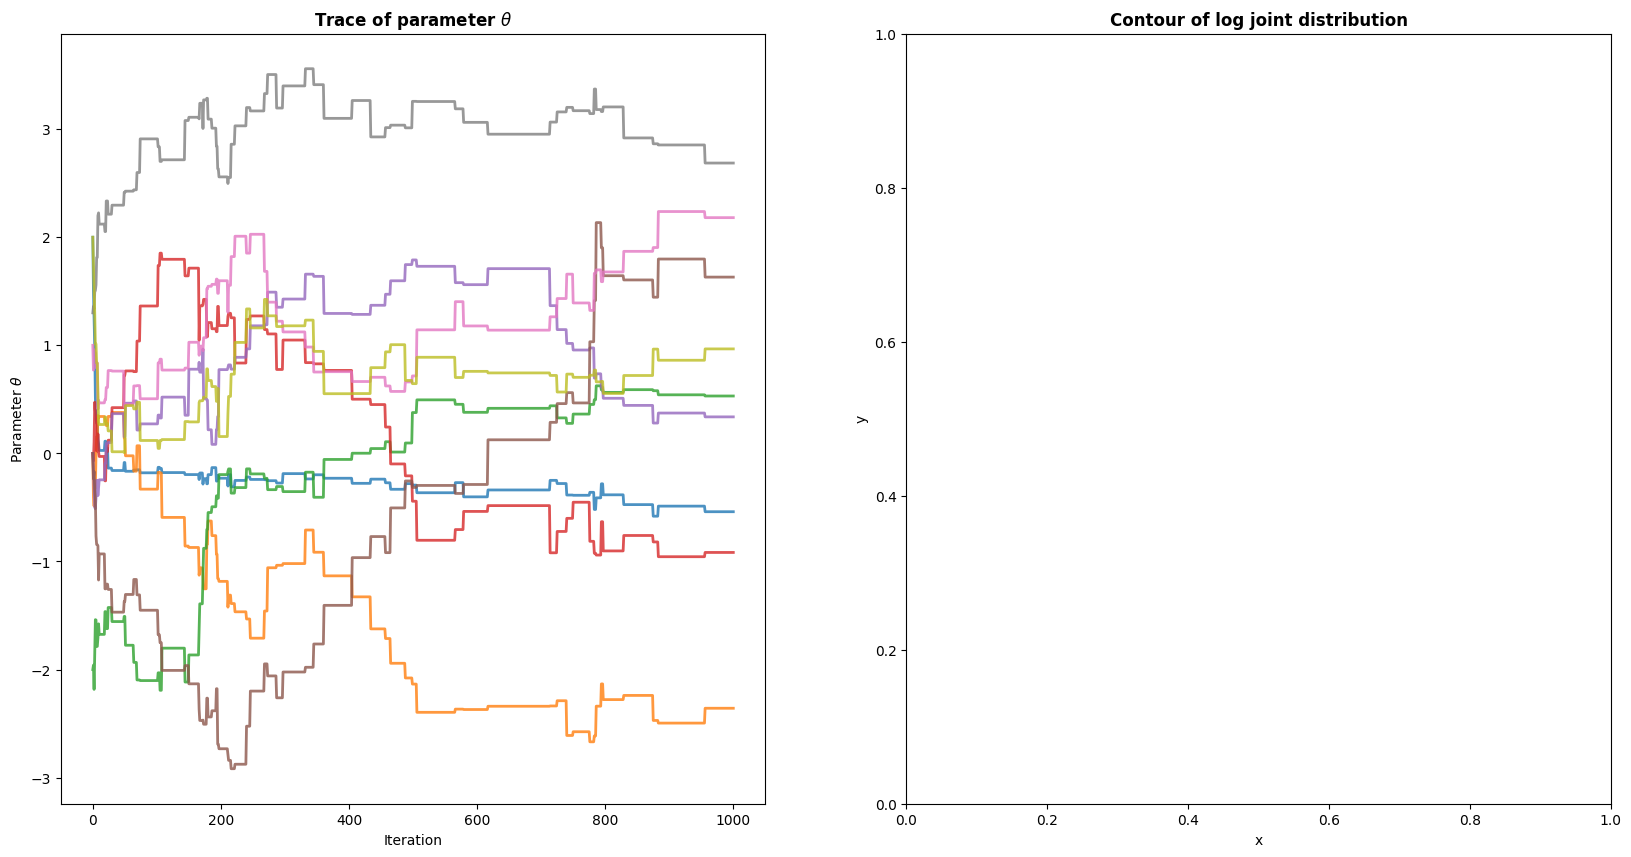

In [57]:
log_npdf = lambda x, mu, var: -0.5*(x-mu)**2/(var) - 0.5*jnp.log(2*jnp.pi*var)

# specify number of parameters in the target distribution
num_params = 9

# target distribution = log joint distribution

num_iterations = 1000
warm_up = int(0.5*num_iterations)
step_size = 0.2

# theta = {w0[0], w0[1], w1[0], w1[1], v[0], v[1], tau, sigm0, sigma1}
theta_init = jnp.array([2,0,-2,0,0,0,1,1.3,2])

log_joint_func_theta = lambda theta: log_joint(x_data, y_data, theta)

# run sampler
thetas,acceptance = MetH(log_joint_func_theta, num_params, step_size, num_iterations, theta_init=theta_init, seed=0)

# plot resutls
xs = np.linspace(-8, 8, 1000)
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
for i in range(num_params):
    axes[0].plot(thetas[:,i], alpha=0.8, linewidth=2)
axes[0].set_xlabel('Iteration')
axes[0].set_ylabel('Parameter $\\theta$')
axes[0].set_title('Trace of parameter $\\theta$', fontweight='bold')

# y_data,x_data meshgrid
x_mesh, y_mesh = np.meshgrid(x_data, y_data)
theta_mean = jnp.mean(thetas[warm_up:], axis=0)
# plot contour of log joint distribution and data
axes[1].set_title('Contour of log joint distribution', fontweight='bold')
axes[1].set_xlabel('x')
axes[1].set_ylabel('y')


log_joint_func_data = lambda x, y: jnp.array([log_joint(xi, yi, theta_mean) for xi, yi in zip(x, y)])

log_joint_grid = log_joint_func_data(x_mesh.ravel(), y_mesh.ravel()).reshape(x_mesh.shape)
axes[1].contourf(x_mesh, y_mesh, log_joint_grid, levels=100, cmap='viridis', alpha=0.8)
axes[1].scatter(x_data, y_data, c='red', s=10, alpha=0.5, label='Data')
axes[1].legend()
plt.show()



**Task 2.4: posterior mean and 95% credibility intervals for all parameters**

In [40]:

# Assuming you already have these:
# thetas, warm_up, theta_init

theta_sample = thetas[warm_up:, :]

# Round to 3 decimals
lower = jnp.round(jnp.percentile(theta_sample, 2.5, axis=0), 3)
upper = jnp.round(jnp.percentile(theta_sample, 97.5, axis=0), 3)
mean = jnp.round(jnp.mean(theta_sample, axis=0), 3)

# Labels with HTML
labels = [
    'w<sub>0</sub>: slope', 'w<sub>0</sub>: intercept', 
    'w<sub>1</sub>: slope', 'w<sub>1</sub>: intercept', 
    'v slope', 'v intercept', 
    '&#x03C4;',              # τ
    '&#x03C3;<sub>0</sub>',  # σ₀
    '&#x03C3;<sub>1</sub>'   # σ₁
]

# Format the intervals as strings: "lower – upper"
low_up = [f"[{l:.3f} ; {u:.3f}]" for l, u in zip(lower, upper)]

# Create DataFrame
cred_int = pd.DataFrame({
    'Parameter': labels,
    'Initial': theta_init,
    'Mean': mean,
    '95%-Credibility interval': low_up,
})

cred_int = cred_int.set_index('Parameter')

# Display with HTML rendering
display(HTML(cred_int.to_html(escape=False)))


,Initial,Mean,95%-Credibility interval
Parameter,,,
w0: slope,2.0,1.468,[1.292 ; 1.569]
w0: intercept,0.0,0.939,[0.403 ; 1.203]
w1: slope,-2.0,-2.180,[-2.369 ; -1.945]
w1: intercept,0.0,-0.492,[-1.120 ; -0.020]
v slope,0.0,1.968,[1.530 ; 2.450]
v intercept,0.0,-0.915,[-1.480 ; -0.134]
τ,1.0,1.732,[0.846 ; 2.751]
σ0,1.3,1.355,[1.239 ; 1.519]
σ1,2.0,4.789,[4.518 ; 5.040]


**Task 2.5: Plot posterior predictive distribution for $p(\pi^*\mid\boldsymbol{y},\boldsymbol{x}^*),\ p(y^*\mid\boldsymbol{y},\boldsymbol{x}^*,z^*=0)$** **and** $p(y^*\mid\boldsymbol{y},\boldsymbol{x}^*,z^*=1)$

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(20, 6))

w0 = jnp.column_stack([theta_sample[:,0], theta_sample[:,1]])
w1 = jnp.column_stack([theta_sample[:,2], theta_sample[:,3]])
v = jnp.column_stack([theta_sample[:,4], theta_sample[:,5]])
tau = theta_sample[:,6]
sigma0 = theta_sample[:,7]
sigma1 = theta_sample[:,8]

X_star = jnp.linspace(-12, 12, 1000)
X_star = jnp.column_stack((X_star, jnp.ones(X_star.shape[0])))
z0 = jnp.zeros(X_star.shape[0])
z1 = jnp.ones(X_star.shape[0])

pi_star_samples = sigmoid(X_star @ v.T) # (N, 2) @ (2, M) = (N, M) 
y_star_z0_samples = log_joint(theta_sample)  # exp(f_star_samples) = (N, M)
y_star_z1_samples =  # (N, M)


**Task 2.6: Plot posterior predictive distribution for $p(y^*\mid\boldsymbol{y},\boldsymbol{x}^*)$**